## 🌐 **Google Drive and Kaggle Connection**

In [1]:
# Install and configure Kaggle API
!pip install -q kaggle

import os
from google.colab import drive
from google.colab import files

# --- Configuration ---
# Percorso di destinazione sul Drive
DRIVE_MOUNT_PATH = "/content/gdrive"
DATASET_PATH = f"{DRIVE_MOUNT_PATH}/MyDrive/Artificial_Neural_Networks/Images_Classification_Challenge/dataset"
COMPETITION_ID = "an2dl2526c2"
ZIP_FILENAME = f"{COMPETITION_ID}.zip"
EXPECTED_ZIP_FILE = os.path.join(DATASET_PATH, ZIP_FILENAME)

# --- 1. Mount Google Drive ---
print("1. Mounting Google Drive...")
# Mount G-Drive if it's not already mounted
if not os.path.exists(DRIVE_MOUNT_PATH):
    drive.mount(DRIVE_MOUNT_PATH)
else:
    print("Drive already mounted.")

# --- 2. Check for Existing Data ---
if os.path.exists(EXPECTED_ZIP_FILE):
    print(f"\n✅ Dataset found at {DATASET_PATH}. Skipping download and setup.")
    # You can also add a check here for the unzipped folders if you prefer.
else:
    # --- 3. Setup Kaggle Credentials (Only if download is needed) ---
    print("\n⏳ Dataset not found. Starting Kaggle setup and download.")

    # 3a. Upload kaggle.json
    print("Carica il file kaggle.json (scaricabile dal tuo profilo Kaggle)")

    # Check if files.upload() returned a file (if running interactively)
    # The uploaded dictionary keys are the filenames.
    uploaded = files.upload()

    if "kaggle.json" in uploaded:
        # 3b. Configura le credenziali
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        print("Kaggle credentials configured.")

        # 3c. Create destination folder and Download
        !mkdir -p {DATASET_PATH}
        print(f"Downloading dataset to: {DATASET_PATH}")
        # Scarica il dataset direttamente da Kaggle nella cartella scelta
        !kaggle competitions download -c {COMPETITION_ID} -p {DATASET_PATH}

    else:
        print("\n⚠️ kaggle.json not uploaded. Cannot proceed with download.")


# --- 4. Decompress Data (Always check for existence before unzipping) ---

EXPECTED_UNZIPPED_FILE = os.path.join(DATASET_PATH, "train_labels.csv")

if os.path.exists(EXPECTED_UNZIPPED_FILE):
    # Check if the key unzipped file is already there
    print(f"\n📦 Data appears to be already unzipped (found: {os.path.basename(EXPECTED_UNZIPPED_FILE)}). Skipping decompression.")

elif os.path.exists(EXPECTED_ZIP_FILE):
    # Only unzip if the zip file is present AND the unzipped files are missing
    print("\n📦 Competition zip found but data not yet extracted. Starting decompression...")

    # -o flag is usually kept for safety, but if you want STRICTLY NO overwrite, you can remove it.
    # For speed optimization, we rely on the outer 'if' block to skip the entire step.
    !unzip -o {EXPECTED_ZIP_FILE} -d {DATASET_PATH}

else:
    # This scenario means neither the zip nor the unzipped files were found.
    # This should only happen if the preceding download step failed or was skipped.
    print("\n⚠️ Cannot decompress: Competition zip file is missing.")

print(f"\nFinal status: Dataset available in: {DATASET_PATH}")

1. Mounting Google Drive...


MessageError: Error: credential propagation was unsuccessful

## ⚙️ **Libraries Import**

In [ ]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import InterpolationMode
!pip install torchview
from torchview import draw_graph

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.9.0+cu126
Device: cpu


## ⏳ **Data Loading**

In [ ]:
import os
import pandas as pd

def delete_samples_from_list(txt_file, img_dir, labels_csv):
    """
    - Reads IDs from the txt file
    # - Converts them into file names like img_XXXX.png
    - Deletes img_XXXX.png and mask_XXXX.png
    - Removes the row in the CSV where sample_index == img_XXXX.png
    """

    # --- 1. Load IDs from the file (without modification)
    with open(txt_file, "r") as f:
        ids_raw = [line.strip() for line in f if line.strip()]

    print(f"IDs to be deleted found: {len(ids_raw)}")

    # --- 2. Create the complete file names as they appear in the CSV
    filenames = [f"img_{idx}.png" for idx in ids_raw]

    # --- 3. Delete images and masks
    removed_files = []

    for fname in filenames:
        img_path  = os.path.join(img_dir, fname)
        mask_path = os.path.join(img_dir, fname.replace("img_", "mask_"))

        for path in (img_path, mask_path):
            if os.path.exists(path):
                os.remove(path)
                removed_files.append(path)

    print(f"🗑️ Deleted {len(removed_files)} image/mask files.")

    # --- 4. Delete the labels from the CSV
    df = pd.read_csv(labels_csv)

    # Ensure the column is a string type
    df["sample_index"] = df["sample_index"].astype(str)

    # Filter out rows where 'sample_index' is in the list of 'filenames'
    df_new = df[~df["sample_index"].isin(filenames)]

    # Save the new DataFrame back to the CSV
    df_new.to_csv(labels_csv, index=False)

    print(f"📄 Remaining labels saved: {len(df_new)}")
    print("✅ Cleanup completed.")

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from PIL import Image

# Define the final directories containing the images/masks
# These are the directories created by the unzipping above.
train_img_dir = os.path.join(DATASET_PATH, "train_data")
test_img_dir = os.path.join(DATASET_PATH, "test_data")
labels_file = os.path.join(DATASET_PATH, "train_labels.csv")

# Delete Shrek images
delete_path = os.path.join(DATASET_PATH, "delete.txt")
delete_samples_from_list(
    txt_file=delete_path,
    img_dir=train_img_dir,
    labels_csv=labels_file
)

# --- Load Labels and Map Classes ---

# Load the labels file
labels_df = pd.read_csv(labels_file)

# The classes are string labels (e.g., 'HER2(+)', 'Luminal B'). We need to map them to integers.
# This also ensures we get the ordered list of class names.
le = LabelEncoder()
labels_df['label_encoded'] = le.fit_transform(labels_df['label']) ## TODO: IS ONE-HOT-ENC BETTER?

# Store the class names and mapping
class_names = list(le.classes_)
num_classes = len(class_names)
class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

print(f"\nFound {len(labels_df)} training samples.")
print(f"Number of classes: {num_classes}")
print(f"Class Names: {class_names}")
print(f"Label Mapping: {class_mapping}")
print(labels_df)




IDs to be deleted found: 151
🗑️ Deleted 0 image/mask files.
📄 Remaining labels saved: 1262
✅ Cleanup completed.

Found 1262 training samples.
Number of classes: 4
Class Names: ['HER2(+)', 'Luminal A', 'Luminal B', 'Triple negative']
Label Mapping: {'HER2(+)': np.int64(0), 'Luminal A': np.int64(1), 'Luminal B': np.int64(2), 'Triple negative': np.int64(3)}
      sample_index            label  label_encoded
0     img_0000.png  Triple negative              3
1     img_0001.png        Luminal A              1
2     img_0002.png        Luminal A              1
3     img_0003.png        Luminal B              2
4     img_0004.png          HER2(+)              0
...            ...              ...            ...
1257  img_1407.png        Luminal B              2
1258  img_1408.png        Luminal B              2
1259  img_1409.png        Luminal A              1
1260  img_1410.png        Luminal A              1
1261  img_1411.png        Luminal A              1

[1262 rows x 3 columns]


In [ ]:
# --- Class Distribution ---

class_counts = labels_df['label'].value_counts().sort_index()
class_percent = labels_df['label'].value_counts(normalize=True).sort_index() * 100

print("\n=== Class Distribution ===")
for cls in class_counts.index:
    print(f"{cls:15}  Count: {class_counts[cls]:4d}   ({class_percent[cls]:5.2f}%)")



=== Class Distribution ===
HER2(+)          Count:  322   (25.52%)
Luminal A        Count:  339   (26.86%)
Luminal B        Count:  445   (35.26%)
Triple negative  Count:  156   (12.36%)




##  **Data Prepocessing**

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2 # Required for color space conversion (LAB)
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms # You need this for the final output

# --- Define Constants (Aligning with your previous code) ---
TRAIN_IMG_DIR = os.path.join(DATASET_PATH, "train_data") # Original directory for WSI patches and masks
LABELS_CSV = os.path.join(DATASET_PATH, "train_labels.csv")


# ---------------------------------------------------------
#  LOADING FUNCTIONS
# ---------------------------------------------------------

def load_rgb(path):
    return Image.open(path).convert("RGB")

def load_mask(path):
    # Mask must be binary {0,255} or boolean convertible
    return Image.open(path).convert("L")


# ---------------------------------------------------------
#  MASK-BASED TUMOR DETECTION
# ---------------------------------------------------------

def mask_active(mask_arr, min_ratio=0.02):
    """
    Returns True if the percentage of active pixels in the mask
    exceeds min_ratio (e.g., 2% of the tile).
    """
    return (mask_arr > 0).mean() >= min_ratio

# ---------------------------------------------------------
#  DETECT GREEN ARTIFACT
# ---------------------------------------------------------

def is_green_artifact_lab(img, a_thresh=100, ratio_thresh=0.01):
    """
    Identifies green artifacts in H&E images using the 'a' channel of LAB color space.
    """
    img_arr = np.array(img)
    # Use cv2 for color space conversion
    lab = cv2.cvtColor(img_arr, cv2.COLOR_RGB2LAB)
    A = lab[:,:,1]  # 'a' channel: red <-> green

    # Pixels where 'a' is low indicate green
    green_pixels = (A < a_thresh)
    ratio = green_pixels.mean()

    return ratio > ratio_thresh


# ---------------------------------------------------------
#  TILE EXTRACTION
# ---------------------------------------------------------

def extract_masked_tiles(img, mask, tile_size=224, stride=168, min_mask_ratio=0.02):
    """
    Divides the image into tiles, keeps those with tumor tissue (via mask),
    and excludes tiles containing green artifacts (via LAB).
    """
    img_arr  = np.array(img)
    mask_arr = np.array(mask)

    H, W = img_arr.shape[:2] # Use image shape for dimensions
    tiles = []

    for y in range(0, H - tile_size + 1, int(stride)):
        for x in range(0, W - tile_size + 1, int(stride)):

            tile_img  = img_arr[y:y+tile_size, x:x+tile_size]
            tile_mask = mask_arr[y:y+tile_size, x:x+tile_size]

            # 1️⃣ Tile without tumor tissue (mask not active) → discarded
            if not mask_active(tile_mask, min_ratio=min_mask_ratio):
                continue

            tile = Image.fromarray(tile_img)

            # 2️⃣ Tile with green artifact → discarded
            if is_green_artifact_lab(tile):
                continue

            # 3️⃣ Clean tumor tile → add to the list
            tiles.append(tile)

    return tiles

def get_stride_for_label(label, tile_size):
    # Overlap more heavily for the least represented class ("Triple Negative")
    if label == 3: # Ensure case matches your label list
        return tile_size * 0.5  # 50% overlap (stride = 128 for tile_size=256)
    else:
        return tile_size * 0.8  # Less overlap (stride = 204.8 for tile_size=256)


In [ ]:
# ---------------------------------------------------------
#  MACENKO NORMALIZATION
# ---------------------------------------------------------
def macenko_normalize(img, Io=240, alpha=1, beta=0.15):
    """
    Robust Macenko stain normalization.
    img: NumPy array RGB uint8
    Returns a normalized uint8 image.
    """
    # Safety check
    if img is None or img.size == 0:
        return img

    img = img.astype(np.float64)

    # Avoid log(0)
    OD = -np.log((img + 1) / Io)

    # Remove transparent pixels
    ODhat = OD.reshape((-1, 3))
    ODhat = ODhat[~np.any(ODhat < beta, axis=1)]

    # If too few pixels, return original (prevents crashes)
    if ODhat.shape[0] < 50:
        return img.astype(np.uint8)

    # SVD
    _, _, V = np.linalg.svd(ODhat, full_matrices=False)

    # Projection onto first two principal directions
    That = ODhat.dot(V.T[:, :2])
    phi = np.arctan2(That[:, 1], That[:, 0])

    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100 - alpha)

    v1 = V.T.dot([np.cos(minPhi), np.sin(minPhi), 0])
    v2 = V.T.dot([np.cos(maxPhi), np.sin(maxPhi), 0])
    HE = np.array([v1, v2]).T

    # Compute concentrations
    C, *_ = np.linalg.lstsq(HE, OD.reshape((-1, 3)).T, rcond=None)

    # Normalize stain concentrations
    maxC = np.percentile(C, 99, axis=1)
    maxC[maxC == 0] = 1
    C = C / maxC[:, None]

    # Reconstruct normalized image
    Inorm = Io * np.exp(-HE.dot(C).T)
    Inorm = np.clip(Inorm.reshape(img.shape), 0, 255).astype(np.uint8)

    return Inorm


In [ ]:
# ---------------------------------------------------------
#  DATASET CLASS
# ---------------------------------------------------------

class HistologyMaskedTiles(Dataset):
    """
    Dataset that performs on-the-fly tiling and filtering of WSI patches.
    """
    def __init__(self, img_dir, labels_df, le, tile_size=256, transform=None,
                 min_mask_ratio=0.02):

        self.img_dir = img_dir
        # Store the DataFrame directly, no need to reload CSV
        self.labels_df = labels_df
        self.le = le # Store the LabelEncoder for mapping
        self.tile_size = tile_size
        self.transform = transform
        self.min_mask_ratio = min_mask_ratio

        # Prepare list of (image_file_path, label_encoded, original_label)
        self.samples = self._prepare_samples()

    def fallback_extract_tiles(self, img, mask, tile_size, stride, min_mask_ratio):

        # progressively relax ratio
        for ratio in [min_mask_ratio * 0.75,
                      min_mask_ratio * 0.5,
                      min_mask_ratio * 0.25,
                      min_mask_ratio * 0.125,
                      0.02]:

            tiles = extract_masked_tiles(
                img, mask,
                tile_size=tile_size,
                stride=stride,
                min_mask_ratio=ratio
            )

            if tiles:
                # pick tile with MAX mask ratio
                best_tile = max(
                    tiles,
                    key=lambda t: (np.array(t.convert("L")) > 0).mean()
                )
                return [best_tile], ratio

        return [], None


    def _prepare_samples(self):
        samples = []
        zero_tile_samples = [] # New list to track problematic samples

        # Iterate over the WSI patches
        for _, row in self.labels_df.iterrows():
            img_name  = row["sample_index"]
            label_str = row["label"]
            label_enc = row["label_encoded"]

            img_path  = os.path.join(self.img_dir, img_name)
            # Assuming masks are in the same folder as images:
            mask_path = img_path.replace("img_", "mask_")

            if not os.path.exists(mask_path):
                print(f"[WARNING] Mask not found for {img_path}")
                continue


            # Load WSI/patch & mask
            img  = load_rgb(img_path)
            mask = load_mask(mask_path)

            # Determine stride based on class label
            stride = get_stride_for_label(label_enc, self.tile_size)

            # Extract tumor tiles
            tiles = extract_masked_tiles(
                img, mask,
                tile_size=self.tile_size,
                stride=stride,
                min_mask_ratio=self.min_mask_ratio
            )

            # --- CRITICAL CHECK: Ensure at least one tile was generated ---
            if not tiles:
                fallback_tiles, used_ratio = self.fallback_extract_tiles(
                    img, mask, self.tile_size, stride, self.min_mask_ratio
                )

                if not fallback_tiles:
                    print(f"[ERROR] No fallback possible for {img_name}")
                    continue

                print(f"[FALLBACK] Using fallback ratio {used_ratio} for {img_name}")
                samples.append((fallback_tiles[0], label_enc))


            else:
                # Save tiles as list (PIL Image, encoded label)
                for t in tiles:
                    samples.append((t, label_enc)) # We save the PIL image object directly

        # --- Final Logging ---
        print(f"Total tiles generated: {len(samples)}")
        return samples

    def __len__(self):
        return len(self.samples)

#------------------------------------------------------------------------------#
# MACENKO NORMALIZATION
#------------------------------------------------------------------------------#
    def __getitem__(self, idx):
      img_pil, label_encoded = self.samples[idx]

      # Convert PIL → NumPy
      img_np = np.array(img_pil)

      # Apply Macenko normalization
      img_np = macenko_normalize(img_np)

      # Convert back to PIL for torchvision transforms
      img_pil = Image.fromarray(img_np)

      # Apply transforms (if any)
      if self.transform is not None:
          img_tensor = self.transform(img_pil)
      else:
          img_tensor = transforms.ToTensor()(img_pil)

      return img_tensor, label_encoded
#------------------------------------------------------------------------------#
    # def __getitem__(self, idx):
    #     img_pil, label_encoded = self.samples[idx]
    #     return img_pil, label_encoded

In [ ]:
## 3. Dataset Instantiation (Tile Generation)

# --- Define the Transform to be used in the __getitem__ ---
# Note: You will need to define your full transform pipeline here later.
# For now, we use a minimal one.

# --- Instantiate the Dataset ---
# tile_size=256 is common. min_mask_ratio=0.1 is a strong filter.
# Using your existing labels_df and le (LabelEncoder)
print("\n--- Starting Tile Generation (This may take several minutes) ---")
tiled_full_dataset = HistologyMaskedTiles(
    img_dir=TRAIN_IMG_DIR,
    labels_df=labels_df, # Pass the DataFrame directly
    le=le,
    tile_size=224,
    transform=None,
    min_mask_ratio=0.1,
)

# Print final confirmation
print(f"Final Tiled Dataset ready with {len(tiled_full_dataset)} individual tiles.")


--- Starting Tile Generation (This may take several minutes) ---
[FALLBACK] Using fallback ratio 0.05 for img_0001.png
[FALLBACK] Using fallback ratio 0.05 for img_0002.png
[FALLBACK] Using fallback ratio 0.05 for img_0005.png
[FALLBACK] Using fallback ratio 0.05 for img_0011.png
[FALLBACK] Using fallback ratio 0.025 for img_0016.png
[ERROR] No fallback possible for img_0026.png
[FALLBACK] Using fallback ratio 0.05 for img_0028.png
[FALLBACK] Using fallback ratio 0.025 for img_0034.png
[FALLBACK] Using fallback ratio 0.05 for img_0044.png
[FALLBACK] Using fallback ratio 0.05 for img_0051.png
[FALLBACK] Using fallback ratio 0.025 for img_0058.png
[FALLBACK] Using fallback ratio 0.05 for img_0061.png
[FALLBACK] Using fallback ratio 0.05 for img_0062.png
[FALLBACK] Using fallback ratio 0.025 for img_0063.png
[FALLBACK] Using fallback ratio 0.05 for img_0064.png
[FALLBACK] Using fallback ratio 0.05 for img_0066.png
[FALLBACK] Using fallback ratio 0.05 for img_0067.png
[FALLBACK] Using fal

##  **📊 Plot of the Prepocessing**

Numero totale di tiles estratti: 4181

Distribuzione delle classi nei tiles:
Triple negative: 1018 tiles
Luminal A: 913 tiles
Luminal B: 1339 tiles
HER2(+): 911 tiles


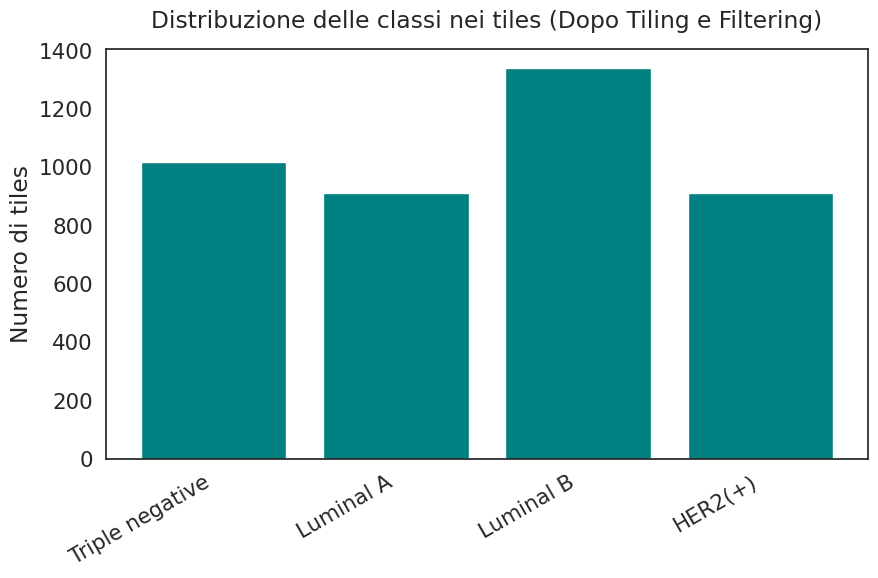

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import random
import math

# Assuming 'tiled_full_dataset' has been successfully created in the previous step
print(f"Numero totale di tiles estratti: {len(tiled_full_dataset)}")


# ---------------------------------------------------------
# 📊 DISTRIBUZIONE DELLE LABELS NEI TILES
# ---------------------------------------------------------

# Extract the encoded labels from the generated samples
labels_encoded = [label for _, label in tiled_full_dataset.samples]
label_counts = Counter(labels_encoded)

# Create a mapping from encoded index back to the string class name for readability
# (Assuming 'class_names' list is defined from the initial LabelEncoder step)
class_label_map = {i: name for i, name in enumerate(class_names)}

print("\nDistribuzione delle classi nei tiles:")
# Print using the human-readable class names
for cls_idx, count in label_counts.items():
    print(f"{class_label_map[cls_idx]}: {count} tiles")

# Bar plot
plt.figure(figsize=(9, 6))
# Use string labels for better visualization
plot_labels = [class_label_map[cls_idx] for cls_idx in label_counts.keys()]
plt.bar(plot_labels, label_counts.values(), color="teal")
plt.title("Distribuzione delle classi nei tiles (Dopo Tiling e Filtering)", pad=15)
plt.ylabel("Numero di tiles")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()




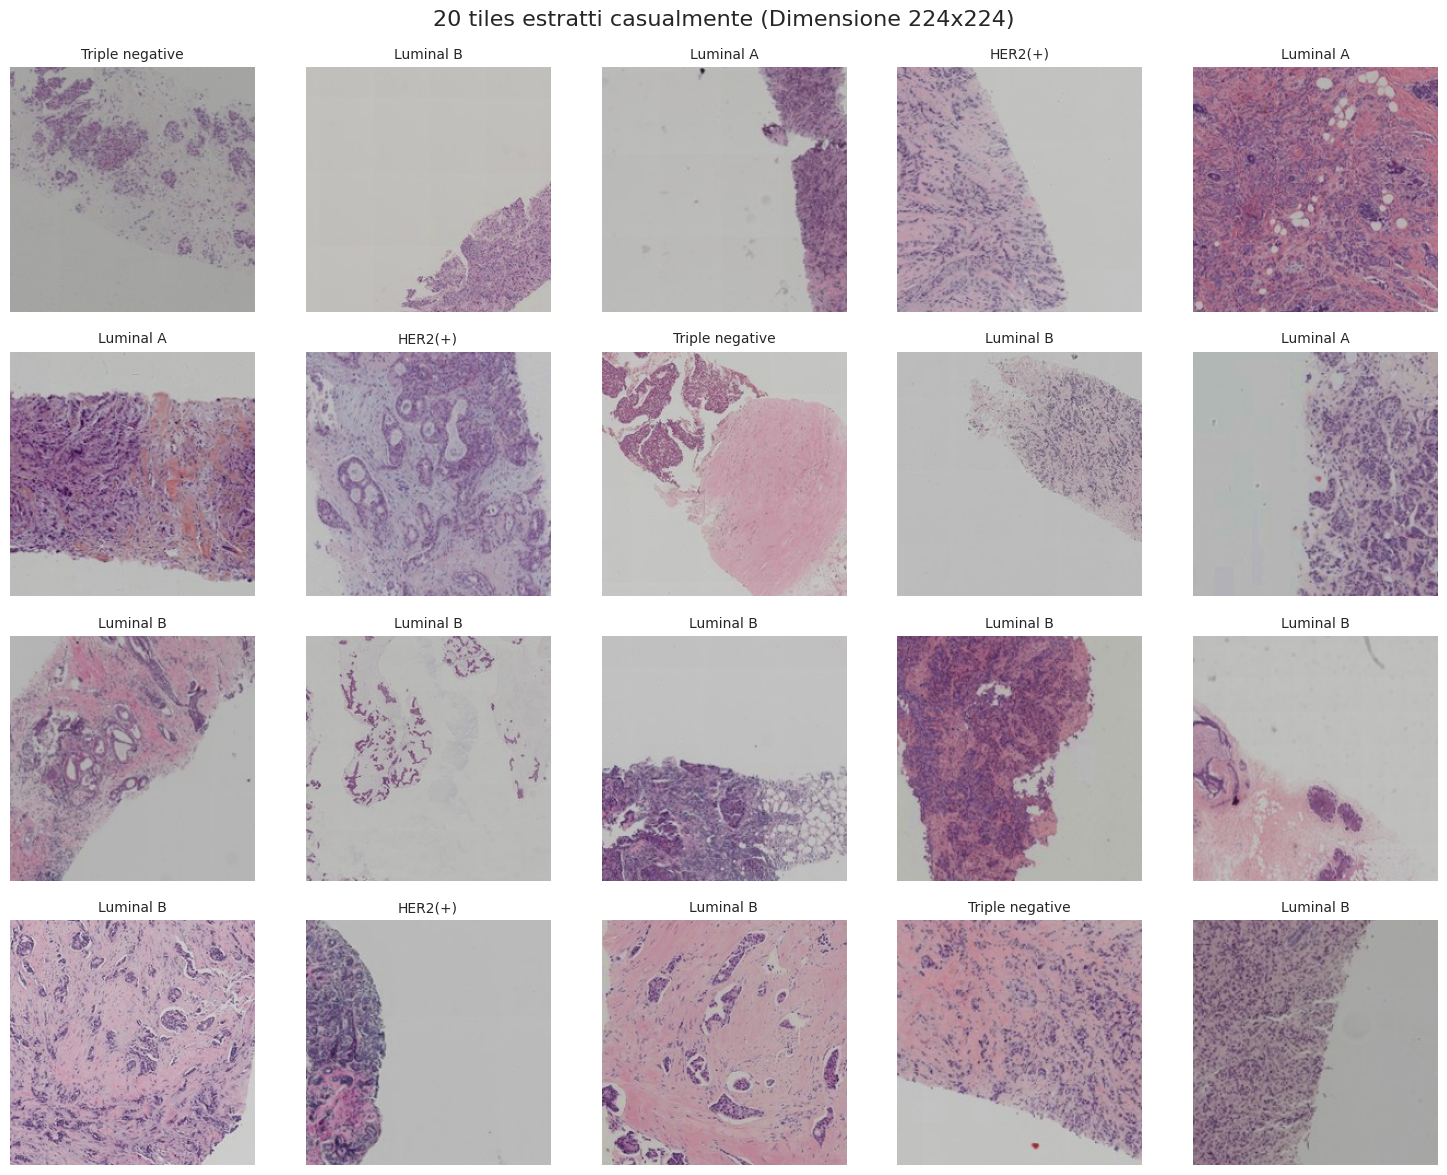

In [ ]:
# ---------------------------------------------------------
# 🖼️ STAMPA DI ALCUNE IMMAGINI DEL DATASET (Corrected)
# ---------------------------------------------------------

def show_random_tiles(dataset, n=20):
    """Visualizza n tiles estratti casualmente dal dataset."""

    idxs = random.sample(range(len(dataset)), n)

    cols = int(math.ceil(math.sqrt(n)))
    rows = int(math.ceil(n / cols))

    plt.figure(figsize=(cols * 3, rows * 3))

    for i, idx in enumerate(idxs):

        img_tensor, label_encoded = dataset[idx]   # now a tensor!

        # Convert tensor → NumPy HWC
        img_np = img_tensor.permute(1, 2, 0).cpu().numpy()

        # Undo normalization if needed (your transform is None, so we're ok)
        img_np = np.clip(img_np, 0, 1)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img_np)

        class_name = class_label_map.get(label_encoded, "Unknown")
        plt.title(class_name, fontsize=10)
        plt.axis("off")

    plt.suptitle(f"{n} tiles estratti casualmente", fontsize=16)
    plt.tight_layout()
    plt.show()


# Re-run the function
show_random_tiles(tiled_full_dataset, n=20)

##  **Data Splitting in Training and Validation Set**

In [ ]:
from torch.utils.data import random_split
import math

# --- Split Parameters ---
VALIDATION_SPLIT_RATIO = 0.15
dataset_size = len(tiled_full_dataset)

# Calculate the sizes for the two subsets
val_size = int(VALIDATION_SPLIT_RATIO * dataset_size)
train_size = dataset_size - val_size

# Log the split details
print(f"\n--- Splitting Tiled Dataset ---")
print(f"Total tiles: {dataset_size}")
print(f"Training tiles: {train_size}")
print(f"Validation tiles: {val_size}")

# Perform the random split
# The function will generate indices and create Subsets based on those indices.
train_dataset, val_dataset = random_split(
    tiled_full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED) # Use your global SEED for reproducibility
)

# Print confirmation
print(f"\n✅ Split successful.")
print(f"Train Dataset (Subset) size: {len(train_dataset)}")
print(f"Validation Dataset (Subset) size: {len(val_dataset)}")


--- Splitting Tiled Dataset ---
Total tiles: 4181
Training tiles: 3554
Validation tiles: 627

✅ Split successful.
Train Dataset (Subset) size: 3554
Validation Dataset (Subset) size: 627


##  **Train and Val Transformation**

In [ ]:
# TODO: Macenko normalization, look at the paper for more details

In [ ]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    #macenko_transform, # Macenko normalization
    # Step 1: Augmentations
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    #Color jitter (adjusts brightness, contrast, saturation)
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.0),
    #Convert to Tensor and Normalize
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Transforms for Validation (minimal, only necessary conversions)
val_transforms = transforms.Compose([
    #macenko_transform, # Macenko normalization
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])
print("\n✅ Transformation pipelines defined.")



✅ Transformation pipelines defined.


In [ ]:
class TransformWrapper(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        # The subset returns (PIL Image, label_encoded)
        image, label = self.subset[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.subset)

# --- Apply the transforms to the split subsets ---
final_train_dataset = TransformWrapper(train_dataset, transform=train_transforms)
final_val_dataset = TransformWrapper(val_dataset, transform=val_transforms)

print(f"Final training dataset size: {len(final_train_dataset)}")
print(f"Final validation dataset size: {len(final_val_dataset)}")

Final training dataset size: 3554
Final validation dataset size: 627


In [ ]:
# --- DataLoader Creation ---
BATCH_SIZE = 32

train_dataloader = DataLoader(
    final_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, # Important for training
    num_workers=2, # Use multiple workers for faster data loading
    pin_memory=True, # Improves speed when transferring data to GPU
)

val_dataloader = DataLoader(
    final_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle validation data
    num_workers=2,
    pin_memory=True,
)

print(f"\n✅ DataLoaders created with BATCH_SIZE={BATCH_SIZE}.")
print(f"Training batches: {len(train_dataloader)}")
print(f"Validation batches: {len(val_dataloader)}")


✅ DataLoaders created with BATCH_SIZE=32.
Training batches: 112
Validation batches: 20


##  🧮 **Network Parameters**

In [ ]:
# Training parameters
LEARNING_RATE = 1e-3
EPOCHS = 200
PATIENCE = 20

# Regularization
DROPOUT_RATE = 0.28

# Set up loss function
criterion = nn.CrossEntropyLoss()

# Print the defined parameters
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rate:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("Patience:", PATIENCE)

Epochs: 200
Batch Size: 32
Learning Rate: 0.001
Dropout Rate: 0.28
Patience: 20


##  🧠 **Training Functions**

In [ ]:
from sklearn.metrics import accuracy_score, f1_score # Ensure f1_score is imported

def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device):
    """Train for one epoch."""
    model.train()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad(set_to_none=True)

        # Automatic Mixed Precision (AMP) block for efficient CUDA utilization
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

        # Scale the loss, backpropagate, and update
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions)
    )

    return epoch_loss, epoch_acc

In [ ]:
def validate_one_epoch(model, val_loader, criterion, device):
    """Validate for one epoch, calculating loss, accuracy, and F1-Score."""
    model.eval()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # AMP block
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_predictions)

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = accuracy_score(y_true, y_pred)

    # Competition Metric: Calculate the Macro F1-Score
    epoch_f1 = f1_score(y_true, y_pred, average='macro')

    return epoch_loss, epoch_accuracy, epoch_f1

In [ ]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        patience=PATIENCE, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=1, experiment_name=""):
    """
    Train the neural network model.
    Evaluation Metric is set to 'val_f1' by default for the competition.
    """

    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1': [] # Added F1-Score tracking
    }

    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    for epoch in range(1, epochs + 1):
        # --- Training Step ---
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device
        )

        # --- Validation Step ---
        # Capture the new F1-Score return value
        val_loss, val_acc, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # --- Update History ---
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_acc'].append(train_acc)
        training_history['val_acc'].append(val_acc)
        training_history['val_f1'].append(val_f1) # Record F1-Score

        # --- TensorBoard Logging ---
        if writer is not None:
            writer.add_scalar('Loss/Training', train_loss, epoch)
            writer.add_scalar('Loss/Validation', val_loss, epoch)
            writer.add_scalar('Accuracy/Training', train_acc, epoch)
            writer.add_scalar('Accuracy/Validation', val_acc, epoch)
            writer.add_scalar('F1-Score/Validation', val_f1, epoch) # Log F1-Score

        # --- Console Output ---
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                      f"Train: Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
                      f"Val: Loss={val_loss:.4f}, Acc={val_acc:.4f}, F1={val_f1:.4f}")

        # --- Early Stopping Logic ---
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                # Save the model state dict
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs (no improvement in {evaluation_metric} for {patience} epochs).")
                    break

    # --- Final Actions ---
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    if patience == 0:
        # Save the final model if no early stopping was used
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    if writer is not None:
        writer.close()

    return model, training_history

## 🛠️ **Transfer Learning resnet18**

In [ ]:
# --- Configuration (Update for ResNet18) ---
MODEL_BACKBONE = 'resnet18'
# DROPOUT_RATE, LEARNING_RATE, EPOCHS, PATIENCE are assumed to be defined globally.
# BATCH_SIZE is assumed to be defined globally (e.g., BATCH_SIZE = 32).
FREEZE_BACKBONE = True # Start with freezing, then fine-tune later
# num_classes is assumed to be defined globally (e.g., num_classes = 4).

# --- Define Input Shape for Summary ---
# ResNet models typically expect 224x224 input, but summary can work with your 256x256 tiles.
# Assuming 3 color channels (RGB)
input_shape = (3, 224, 224)

In [ ]:
class ResNet18TransferLearning(nn.Module):
    """
    ResNet18 with pretrained weights for transfer learning.

    IMPORTANT: This model expects ImageNet-normalized inputs!
    Images should be normalized with mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]
    """

    def __init__(self, num_classes, dropout_rate=0.3, freeze_backbone=True):
        super().__init__()

        # ResNet18 backbone with ImageNet pretrained weights
        self.backbone = torchvision.models.resnet18(
            weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        )

        # Freeze backbone if requested
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False


        # Replace the final fully connected layer (always trainable)
        # ResNet models use 'fc' for the classifier head
        in_features = self.backbone.fc.in_features

        # Create a new, custom classifier head
        # Adding an extra layer and Dropout is good practice for regularization
        # self.backbone.fc = nn.Sequential(
        #     nn.Linear(in_features, in_features // 2),  # Custom intermediate layer
        #     nn.ReLU(),
        #     nn.Dropout(dropout_rate),
        #     nn.Linear(in_features // 2, num_classes)
        # )

        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.25),

            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.15),

            nn.Linear(128, num_classes)
        )


    def forward(self, x):
        return self.backbone(x)

In [ ]:
# Create transfer learning model
# NOTE: Ensure num_classes is defined (it should be 4 from your earlier code)
tl_model = ResNet18TransferLearning(
    num_classes,
    DROPOUT_RATE,
    freeze_backbone=FREEZE_BACKBONE,
).to(device)

print(f"Model created: {MODEL_BACKBONE} (Backbone frozen: {FREEZE_BACKBONE})")

# Display model summary
summary(tl_model, input_size=input_shape)
# The torchview code is commented out as it relies on an external library and can be slow:
# model_graph = draw_graph(tl_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=6)
# model_graph.visual_graph

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 120MB/s]


Model created: resnet18 (Backbone frozen: True)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]        

In [ ]:
# --- Setup Training ---
# Assumed to be defined globally: train_dataloader, val_dataloader, criterion, BATCH_SIZE, LEARNING_RATE, EPOCHS, PATIENCE, fit function.

# Print the defined parameters
print("\n--- Training Parameters ---")
print("Model Backbone:", MODEL_BACKBONE)
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rate:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("Patience (Early Stopping):", PATIENCE)
print("Loss Function:", criterion.__class__.__name__)


experiment_name = f"tl_{MODEL_BACKBONE}_{'frozen' if FREEZE_BACKBONE else 'finetune'}"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)


# Optimizer: Only optimize trainable parameters (the new classification head)
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, tl_model.parameters()),
    lr=LEARNING_RATE
)
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

print(f"\nStarting training for experiment: {experiment_name}")

# %%time (Use this magic command in your notebook cell)
# Train with transfer learning
# NOTE: This assumes your 'fit' function is defined correctly in a preceding cell.
tl_model, tl_history = fit(
    model=tl_model,
    train_loader=train_dataloader, # Use the global loader defined earlier
    val_loader=val_dataloader,      # Use the global loader defined earlier
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=5,
    experiment_name=experiment_name,
    patience=PATIENCE,
    evaluation_metric='val_f1' # Prioritize the competition metric
)


--- Training Parameters ---
Model Backbone: resnet18
Epochs: 200
Batch Size: 32
Learning Rate: 0.001
Dropout Rate: 0.28
Patience (Early Stopping): 20
Loss Function: CrossEntropyLoss

Starting training for experiment: tl_resnet18_frozen
Training 200 epochs...


## **Inference Transfer Learning**

In [ ]:
def extract_test_masked_tiles(img, mask, tile_size=224, stride=112, min_mask_ratio=0.02):
    """
    Divides the image into tiles, keeps those with tumor tissue (via mask).
    """
    img_arr  = np.array(img)
    mask_arr = np.array(mask)

    H, W = img_arr.shape[:2] # Use image shape for dimensions
    tiles = []

    for y in range(0, H - tile_size + 1, int(stride)):
        for x in range(0, W - tile_size + 1, int(stride)):

            tile_img  = img_arr[y:y+tile_size, x:x+tile_size]
            tile_mask = mask_arr[y:y+tile_size, x:x+tile_size]

            # 1️⃣ Tile without tumor tissue (mask not active) → discarded
            if not mask_active(tile_mask, min_ratio=min_mask_ratio):
                continue

            tile = Image.fromarray(tile_img)

            # In test we don't check for green artifact, there aren't

            # 3️⃣ Clean tumor tile → add to the list
            tiles.append(tile)

    return tiles

In [ ]:
class HistologyMaskedTilesTest(Dataset):
    def __init__(self, img_dir, tile_size=224, min_mask_ratio=0.02, transform=None):
        self.img_dir = img_dir
        self.tile_size = tile_size
        self.min_mask_ratio = min_mask_ratio
        self.transform = transform

        self.sample_names = sorted([f for f in os.listdir(img_dir) if f.startswith("img_")])
        self.tiles = self._generate_tiles()

    def fallback_extract(self, img, mask, stride):
        for ratio in [self.min_mask_ratio * 0.75,
                      self.min_mask_ratio * 0.5,
                      self.min_mask_ratio * 0.25,
                      self.min_mask_ratio * 0.1,
                      0.01]:
            tiles = extract_masked_tiles(img, mask,
                                         tile_size=self.tile_size,
                                         stride=stride,
                                         min_mask_ratio=ratio)
            if tiles:
                return tiles
        return []

    def _generate_tiles(self):
        all_tiles = []

        for img_name in self.sample_names:
            img_path = os.path.join(self.img_dir, img_name)
            mask_path = img_path.replace("img_", "mask_")

            img  = load_rgb(img_path)
            mask = load_mask(mask_path)

            stride = int(self.tile_size * 0.8)

            tiles = extract_masked_tiles(img, mask,
                                         tile_size=self.tile_size,
                                         stride=stride,
                                         min_mask_ratio=self.min_mask_ratio)

            if not tiles:
                tiles = self.fallback_extract(img, mask, stride)

            if not tiles:
                print(f"[WARNING] No tiles found for {img_name} — inserting 1 tile (center crop)")
                w, h = img.size
                cx, cy = w//2, h//2
                t = img.crop((cx-112, cy-112, cx+112, cy+112))
                tiles = [t]

            for t in tiles:
                all_tiles.append((t, img_name))

        print(f"[TEST] Total tiles generated: {len(all_tiles)}")
        return all_tiles

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, idx):
        tile_pil, sample_name = self.tiles[idx]

        img_np = np.array(tile_pil)
        img_np = macenko_normalize(img_np)
        tile_pil = Image.fromarray(img_np)

        if self.transform is not None:
            tile_tensor = self.transform(tile_pil)
        else:
            tile_tensor = transforms.ToTensor()(tile_pil)

        return tile_tensor, sample_name


In [ ]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [ ]:
test_dataset = HistologyMaskedTilesTest(
    img_dir=test_img_dir,
    tile_size=224,
    min_mask_ratio=0.1,
    transform=test_transforms
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

[TEST] Total tiles generated: 2563


In [ ]:
print("Unique slide names in loader:", len(set([n for _, batch_names in test_loader for n in batch_names])))
print(len(os.listdir(test_img_dir)))


Unique slide names in loader: 694
1908


In [ ]:
import torch.nn.functional as F
from collections import defaultdict

def infer(model, loader, device):
    model.eval()
    slide_probs = defaultdict(list)

    with torch.no_grad():
        for images, names in loader:
            images = images.to(device)
            logits = model(images)
            probs  = F.softmax(logits, dim=1)

            for p, name in zip(probs, names):
                slide_probs[name].append(p.cpu())

    predictions = {}
    for slide, prob_list in slide_probs.items():
        mean_prob = torch.stack(prob_list).mean(dim=0)
        pred = mean_prob.argmax().item()
        predictions[slide] = pred

    return predictions


In [ ]:
# Run inference on the fine-tuned model
preds = infer(ft_model, test_loader, device)

# Convert numeric → text labels
int_to_label = {i: label for i, label in enumerate(le.classes_)}
preds_text = {
    sample: int_to_label[pred]
    for sample, pred in preds.items()
}

# Generate ordered list of expected filenames
expected_indices = [f"img_{i:04d}.png" for i in range(954)]

final_rows = []
for name in expected_indices:
    if name in preds_text:
        final_rows.append((name, preds_text[name]))
    else:
        print("❌ ERRORE: manca", name)
        final_rows.append((name, "HER2(+)"))  # fallback label (modificabile)

df = pd.DataFrame(final_rows, columns=["sample_index", "label"])
df.to_csv("submission.csv", index=False)

print("Saved submission.csv")
files.download("submission.csv")


Saved 224_bigger_mlp_head.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Estrai gli indici numerici dalla forma "img_XXXX.png"
predicted = set(
    int(name.replace("img_", "").replace(".png", ""))
    for name in preds.keys()
)

expected = set(range(954))

missing = sorted(list(expected - predicted))

print("Numero label mancanti:", len(missing))
print("Label mancanti:", missing[:50])  # Stampa solo le prime 50

Numero label mancanti: 260
Label mancanti: [0, 1, 2, 3, 7, 10, 16, 19, 28, 35, 38, 40, 44, 47, 49, 50, 54, 57, 63, 69, 77, 78, 87, 95, 104, 106, 107, 108, 114, 118, 123, 136, 139, 143, 144, 148, 152, 153, 154, 155, 158, 164, 166, 168, 170, 175, 176, 178, 179, 181]


In [ ]:
############## TEMPORARY FILLING OF MISSING LABELS WITH DOMINANT CLASS#################

preds = infer(tl_model, test_loader, device)

# 4. Convert numeric predictions to text labels
int_to_label = {i: label for i, label in enumerate(le.classes_)}

preds_text = {
    sample: int_to_label[pred]
    for sample, pred in preds.items()
}

# ----------------------------------------------------
# NEW PART: Include missing samples in the final CSV
# ----------------------------------------------------

expected_indices = range(954)  # full range

final_rows = []

for idx in expected_indices:
    sample_name = f"img_{idx:04d}.png"
    if sample_name in preds_text:
        label = preds_text[sample_name]
    else:
        label = "Luminal B"     # <--- fill label for missing samples

    final_rows.append((sample_name, label))

# 5. Build final dataframe
df = pd.DataFrame(final_rows, columns=["sample_index", "label"])

df.to_csv("224_bigger_mlp_head.csv", index=False)
print("Saved 224_bigger_mlp_head.csv")

from google.colab import files
files.download("224_bigger_mlp_head.csv")


# Optional: report missing
predicted = set(
    int(name.replace("img_", "").replace(".png", ""))
    for name in preds.keys()
)

expected = set(range(954))
missing = sorted(list(expected - predicted))

print("Numero label mancanti:", len(missing))
print("Label mancanti:", missing[:50])


Saved 224_bigger_mlp_head.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Numero label mancanti: 260
Label mancanti: [0, 1, 2, 3, 7, 10, 16, 19, 28, 35, 38, 40, 44, 47, 49, 50, 54, 57, 63, 69, 77, 78, 87, 95, 104, 106, 107, 108, 114, 118, 123, 136, 139, 143, 144, 148, 152, 153, 154, 155, 158, 164, 166, 168, 170, 175, 176, 178, 179, 181]


## 🛠️ **Fine-Tuning**

In [ ]:
##MODEL_NAME_FROM_TRANSFER_LEARNING##
# MODEL_NAME_FROM_TRANSFER_LEARNING = tl_resnet18_frozen_model.pt

# --- Configuration (Reuse previous constants) ---
# Assuming these are defined:
# num_classes, DROPOUT_RATE, device
# EPOCHS, PATIENCE, criterion

FT_LEARNING_RATE = 1e-4 # Lower learning rate for fine-tuning

# --- Load Model (Unfrozen) ---
# Create the model instance with all layers potentially trainable
ft_model = ResNet18TransferLearning(
    num_classes,
    DROPOUT_RATE,
    freeze_backbone=False # We handle freezing manually below
).to(device)

# Load the weights saved from the initial transfer learning (frozen backbone) stage
# NOTE: Exploiting model saving in 'fit' function torch.save(model.state_dict(), "models/transfer_learning_model.pt")
try:
    ft_model.load_state_dict(torch.load("models/tl_resnet18_frozen_model.pt"))
    print("✅ Successfully loaded weights from initial transfer learning stage.")
except FileNotFoundError:
    print("⚠️ WARNING: Could not find 'models/transfer_learning_model.pt'. Starting from scratch weights.")

# --- ResNet18 Layer Unfreezing Strategy ---

# ResNet18 layers are structured as: conv1, bn1, layer1, layer2, layer3, layer4, fc
# We want to primarily unfreeze layers starting from the end of the backbone.
# The 'backbone' layers are typically considered: layer4, layer3, layer2, etc.

# Layers in ResNet18 that contain feature extraction blocks:
resnet_feature_blocks = [
    ft_model.backbone.layer4,  # Last block (highest resolution features)
    ft_model.backbone.layer3,
    ft_model.backbone.layer2,
    ft_model.backbone.layer1,
]

# Set the number of feature *blocks* to unfreeze (e.g., the last 2 blocks: layer4 and layer3)
N_BLOCKS_TO_UNFREEZE = 2

# 1. First, freeze the entire backbone (excluding the 'fc' head, which is already handled)
for name, param in ft_model.named_parameters():
    # Only freeze parameters belonging to the backbone, not the final classifier ('fc')
    if 'fc' not in name:
        param.requires_grad = False

# 2. Unfreeze the last N blocks
unfrozen_blocks = resnet_feature_blocks[:N_BLOCKS_TO_UNFREEZE] # e.g., layer4 and layer3
unfrozen_names = []

for i, block in enumerate(unfrozen_blocks):
    for name, param in block.named_parameters():
        param.requires_grad = True
        unfrozen_names.append(f"backbone.layer{4-i}") # layer4, layer3, etc.

print(f"\nFine-tuning setup: Unfreezing the last {N_BLOCKS_TO_UNFREEZE} feature blocks.")

✅ Successfully loaded weights from initial transfer learning stage.

Fine-tuning setup: Unfreezing the last 2 feature blocks.


In [ ]:
# Count trainable parameters
total_params = sum(p.numel() for p in ft_model.parameters())
trainable_params = sum(p.numel() for p in ft_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")

# Display which layers are trainable
print("\nTrainable layers:")
for name, param in ft_model.named_parameters():
    if param.requires_grad:
        # Only print the layer/block name once
        if any(f"backbone.{block_name}" in name for block_name in ["layer4", "layer3", "layer2", "layer1", "fc"]):
            layer_name = name.split('.')[1]
        else:
            layer_name = name

        print(f"  {name} ({param.numel():,} parameters)")


Total parameters: 11,506,628
Trainable parameters: 10,823,556
Frozen parameters: 683,072

Trainable layers:
  backbone.layer3.0.conv1.weight (294,912 parameters)
  backbone.layer3.0.bn1.weight (256 parameters)
  backbone.layer3.0.bn1.bias (256 parameters)
  backbone.layer3.0.conv2.weight (589,824 parameters)
  backbone.layer3.0.bn2.weight (256 parameters)
  backbone.layer3.0.bn2.bias (256 parameters)
  backbone.layer3.0.downsample.0.weight (32,768 parameters)
  backbone.layer3.0.downsample.1.weight (256 parameters)
  backbone.layer3.0.downsample.1.bias (256 parameters)
  backbone.layer3.1.conv1.weight (589,824 parameters)
  backbone.layer3.1.bn1.weight (256 parameters)
  backbone.layer3.1.bn1.bias (256 parameters)
  backbone.layer3.1.conv2.weight (589,824 parameters)
  backbone.layer3.1.bn2.weight (256 parameters)
  backbone.layer3.1.bn2.bias (256 parameters)
  backbone.layer4.0.conv1.weight (1,179,648 parameters)
  backbone.layer4.0.bn1.weight (512 parameters)
  backbone.layer4.0.bn1

In [ ]:
# --- Reuse Datasets and Create DataLoaders ---
# NOTE: Using the existing DataLoaders (train_dataloader, val_dataloader) created after the split.

train_ft_loader = train_dataloader
val_ft_loader = val_dataloader

# Setup training with lower learning rate for fine-tuning
experiment_name = f"fine_tuning_{MODEL_BACKBONE}_{N_BLOCKS_TO_UNFREEZE}blocks"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)

print(f"\nStarting fine-tuning for experiment: {experiment_name}")

# Optimizer: Optimize all trainable parameters (frozen layers are ignored)
optimizer = torch.optim.Adam(
    ft_model.parameters(),
    lr=FT_LEARNING_RATE # Use the lower learning rate
)
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

# %%time
# Fine-tune the model
ft_model, ft_history = fit(
    model=ft_model,
    train_loader=train_ft_loader,
    val_loader=val_ft_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=5,
    experiment_name="fine_tuning",
    patience=PATIENCE,
    evaluation_metric='val_f1' # Continue prioritizing the competition metric
)

# --- Final Results ---
# Find the best F1-score from the history (assuming your 'fit' function logs this)
if ft_history and 'val_f1' in ft_history:
    final_val_f1 = round(max(ft_history['val_f1']) * 100, 2)
    print(f'\nFinal validation F1-Score: {final_val_f1}%')
else:
     print("\nTraining complete. Review history for best metrics.")


Starting fine-tuning for experiment: fine_tuning_resnet18_2blocks
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.1128, Acc=0.5047 | Val: Loss=2.0159, Acc=0.5141, F1=0.5122
Epoch   5/200 | Train: Loss=0.9215, Acc=0.6128 | Val: Loss=1.0332, Acc=0.6066, F1=0.5947
Epoch  10/200 | Train: Loss=0.7661, Acc=0.6842 | Val: Loss=0.9966, Acc=0.6458, F1=0.6418
Epoch  15/200 | Train: Loss=0.6225, Acc=0.7605 | Val: Loss=0.8454, Acc=0.6661, F1=0.6626
Epoch  20/200 | Train: Loss=0.5140, Acc=0.8072 | Val: Loss=1.6222, Acc=0.6959, F1=0.6888
Epoch  25/200 | Train: Loss=0.4414, Acc=0.8346 | Val: Loss=0.9757, Acc=0.6944, F1=0.6893
Epoch  30/200 | Train: Loss=0.3555, Acc=0.8700 | Val: Loss=1.3242, Acc=0.7022, F1=0.6934
Epoch  35/200 | Train: Loss=0.2898, Acc=0.8952 | Val: Loss=0.9987, Acc=0.7367, F1=0.7292
Epoch  40/200 | Train: Loss=0.2748, Acc=0.8971 | Val: Loss=0.8955, Acc=0.7226, F1=0.7198
Epoch  45/200 | Train: Loss=0.2439, Acc=0.9121 | Val: Loss=0.8751, Acc=0.7257, F1=0.7206
Epoch  50/200 | Trai

## **Inference Fine Tuning**

In [ ]:
def extract_test_masked_tiles(img, mask, tile_size=224, stride=112, min_mask_ratio=0.02):
    """
    Divides the image into tiles, keeps those with tumor tissue (via mask).
    """
    img_arr  = np.array(img)
    mask_arr = np.array(mask)

    H, W = img_arr.shape[:2] # Use image shape for dimensions
    tiles = []

    for y in range(0, H - tile_size + 1, int(stride)):
        for x in range(0, W - tile_size + 1, int(stride)):

            tile_img  = img_arr[y:y+tile_size, x:x+tile_size]
            tile_mask = mask_arr[y:y+tile_size, x:x+tile_size]

            # 1️⃣ Tile without tumor tissue (mask not active) → discarded
            if not mask_active(tile_mask, min_ratio=min_mask_ratio):
                continue

            tile = Image.fromarray(tile_img)

            # In test we don't check for green artifact, there aren't

            # 3️⃣ Clean tumor tile → add to the list
            tiles.append(tile)

    return tiles

In [ ]:
class HistologyMaskedTilesTest(Dataset):
    def __init__(self, img_dir, tile_size=224, min_mask_ratio=0.02, transform=None):
        self.img_dir = img_dir
        self.tile_size = tile_size
        self.min_mask_ratio = min_mask_ratio
        self.transform = transform

        self.sample_names = sorted([f for f in os.listdir(img_dir) if f.startswith("img_")])
        self.tiles = self._generate_tiles()

    def fallback_extract(self, img, mask, stride):
        for ratio in [self.min_mask_ratio * 0.75,
                      self.min_mask_ratio * 0.5,
                      self.min_mask_ratio * 0.25,
                      self.min_mask_ratio * 0.1,
                      0.01]:
            tiles = extract_masked_tiles(img, mask,
                                         tile_size=self.tile_size,
                                         stride=stride,
                                         min_mask_ratio=ratio)
            if tiles:
                return tiles
        return []

    def _generate_tiles(self):
        all_tiles = []

        for img_name in self.sample_names:
            img_path = os.path.join(self.img_dir, img_name)
            mask_path = img_path.replace("img_", "mask_")

            img  = load_rgb(img_path)
            mask = load_mask(mask_path)

            stride = int(self.tile_size * 0.8)

            tiles = extract_masked_tiles(img, mask,
                                         tile_size=self.tile_size,
                                         stride=stride,
                                         min_mask_ratio=self.min_mask_ratio)

            if not tiles:
                tiles = self.fallback_extract(img, mask, stride)

            if not tiles:
                print(f"[WARNING] No tiles found for {img_name} — inserting 1 tile (center crop)")
                w, h = img.size
                cx, cy = w//2, h//2
                t = img.crop((cx-112, cy-112, cx+112, cy+112))
                tiles = [t]

            for t in tiles:
                all_tiles.append((t, img_name))

        print(f"[TEST] Total tiles generated: {len(all_tiles)}")
        return all_tiles

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, idx):
        tile_pil, sample_name = self.tiles[idx]

        img_np = np.array(tile_pil)
        img_np = macenko_normalize(img_np)
        tile_pil = Image.fromarray(img_np)

        if self.transform is not None:
            tile_tensor = self.transform(tile_pil)
        else:
            tile_tensor = transforms.ToTensor()(tile_pil)

        return tile_tensor, sample_name


In [ ]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [ ]:
test_dataset = HistologyMaskedTilesTest(
    img_dir=test_img_dir,
    tile_size=224,
    min_mask_ratio=0.1,
    transform=test_transforms
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

[TEST] Total tiles generated: 2563


In [ ]:
print("Unique slide names in loader:", len(set([n for _, batch_names in test_loader for n in batch_names])))
print(len(os.listdir(test_img_dir)))


Unique slide names in loader: 694
1908


In [ ]:
import torch.nn.functional as F
from collections import defaultdict

def infer(model, loader, device):
    model.eval()
    slide_probs = defaultdict(list)

    with torch.no_grad():
        for images, names in loader:
            images = images.to(device)
            logits = model(images)
            probs  = F.softmax(logits, dim=1)

            for p, name in zip(probs, names):
                slide_probs[name].append(p.cpu())

    predictions = {}
    for slide, prob_list in slide_probs.items():
        mean_prob = torch.stack(prob_list).mean(dim=0)
        pred = mean_prob.argmax().item()
        predictions[slide] = pred

    return predictions


In [ ]:
# Run inference on the fine-tuned model
preds = infer(ft_model, test_loader, device)

# Convert numeric → text labels
int_to_label = {i: label for i, label in enumerate(le.classes_)}
preds_text = {
    sample: int_to_label[pred]
    for sample, pred in preds.items()
}

# Generate ordered list of expected filenames
expected_indices = [f"img_{i:04d}.png" for i in range(954)]

final_rows = []
for name in expected_indices:
    if name in preds_text:
        final_rows.append((name, preds_text[name]))
    else:
        print("❌ ERRORE: manca", name)
        final_rows.append((name, "HER2(+)"))  # fallback label (modificabile)

df = pd.DataFrame(final_rows, columns=["sample_index", "label"])
df.to_csv("submission.csv", index=False)

print("Saved submission.csv")
files.download("submission.csv")


Saved 224_bigger_mlp_head.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Estrai gli indici numerici dalla forma "img_XXXX.png"
predicted = set(
    int(name.replace("img_", "").replace(".png", ""))
    for name in preds.keys()
)

expected = set(range(954))

missing = sorted(list(expected - predicted))

print("Numero label mancanti:", len(missing))
print("Label mancanti:", missing[:50])  # Stampa solo le prime 50

Numero label mancanti: 260
Label mancanti: [0, 1, 2, 3, 7, 10, 16, 19, 28, 35, 38, 40, 44, 47, 49, 50, 54, 57, 63, 69, 77, 78, 87, 95, 104, 106, 107, 108, 114, 118, 123, 136, 139, 143, 144, 148, 152, 153, 154, 155, 158, 164, 166, 168, 170, 175, 176, 178, 179, 181]


In [ ]:
############## TEMPORARY FILLING OF MISSING LABELS WITH DOMINANT CLASS#################

preds = infer(ft_model, test_loader, device)

# 4. Convert numeric predictions to text labels
int_to_label = {i: label for i, label in enumerate(le.classes_)}

preds_text = {
    sample: int_to_label[pred]
    for sample, pred in preds.items()
}

# ----------------------------------------------------
# NEW PART: Include missing samples in the final CSV
# ----------------------------------------------------

expected_indices = range(954)  # full range

final_rows = []

for idx in expected_indices:
    sample_name = f"img_{idx:04d}.png"
    if sample_name in preds_text:
        label = preds_text[sample_name]
    else:
        label = "Luminal B"     # <--- fill label for missing samples

    final_rows.append((sample_name, label))

# 5. Build final dataframe
df = pd.DataFrame(final_rows, columns=["sample_index", "label"])

df.to_csv("224_bigger_mlp_head.csv", index=False)
print("Saved 224_bigger_mlp_head.csv")

from google.colab import files
files.download("224_bigger_mlp_head.csv")


# Optional: report missing
predicted = set(
    int(name.replace("img_", "").replace(".png", ""))
    for name in preds.keys()
)

expected = set(range(954))
missing = sorted(list(expected - predicted))

print("Numero label mancanti:", len(missing))
print("Label mancanti:", missing[:50])


Saved 224_bigger_mlp_head.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Numero label mancanti: 260
Label mancanti: [0, 1, 2, 3, 7, 10, 16, 19, 28, 35, 38, 40, 44, 47, 49, 50, 54, 57, 63, 69, 77, 78, 87, 95, 104, 106, 107, 108, 114, 118, 123, 136, 139, 143, 144, 148, 152, 153, 154, 155, 158, 164, 166, 168, 170, 175, 176, 178, 179, 181]


## 🛠️ **Transfer Learning mobilenet_v3_small**

In [ ]:
# --- Configuration ---
MODEL_BACKBONE = 'mobilenet_v3_small'
DROPOUT_RATE = 0.3 # Use your defined parameter
FREEZE_BACKBONE = True # Start with freezing, then fine-tune later

In [ ]:
class MobileNetV3TransferLearning(nn.Module):
    """
    MobileNetV3Small with pretrained weights for transfer learning.

    IMPORTANT: This model expects ImageNet-normalized inputs!
    Images should be normalized with mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]
    """

    def __init__(self, num_classes, dropout_rate=0.3, freeze_backbone=True):
        super().__init__()

        # MobileNetV3Small backbone with ImageNet pretrained weights
        self.backbone = torchvision.models.mobilenet_v3_small(
            weights=torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
        )

        # Freeze backbone if requested
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        # Replace classifier (always trainable)
        in_features = self.backbone.classifier[0].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.Hardswish(),
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

In [ ]:
# Create transfer learning model
tl_model = MobileNetV3TransferLearning(
    num_classes,
    DROPOUT_RATE,
    freeze_backbone=FREEZE_BACKBONE,
).to(device)

print(f"Model created: {MODEL_BACKBONE} (Backbone frozen: {FREEZE_BACKBONE})")

# Display model summary
summary(tl_model, input_size=input_shape)
# model_graph = draw_graph(tl_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=6)
# model_graph.visual_graph

Model created: mobilenet_v3_small (Backbone frozen: True)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             432
       BatchNorm2d-2         [-1, 16, 256, 256]              32
         Hardswish-3         [-1, 16, 256, 256]               0
            Conv2d-4         [-1, 16, 128, 128]             144
       BatchNorm2d-5         [-1, 16, 128, 128]              32
              ReLU-6         [-1, 16, 128, 128]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12         [-1, 16, 128, 128]               0
           Conv2d-13         [-1, 16, 128, 12

In [ ]:
# --- Setup Training ---
# Note: Ensure train_loader, val_loader, criterion, and the constant BATCH_SIZE
# are defined in the cells above.

experiment_name = f"tl_{MODEL_BACKBONE}_{'frozen' if FREEZE_BACKBONE else 'finetune'}"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)

# Optimizer: Only optimize trainable parameters (the new classification head)
# If freeze_backbone=False, all parameters will be optimized.
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, tl_model.parameters()),
    lr=LEARNING_RATE
)
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

print(f"\nStarting training for experiment: {experiment_name}")

# %%time (Use this magic command in your notebook cell)
# Train with transfer learning
tl_model, tl_history = fit(
    model=tl_model,
    train_loader=train_loader, # Use the global loader defined earlier
    val_loader=val_loader,     # Use the global loader defined earlier
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=5,
    experiment_name=experiment_name,
    patience=PATIENCE,
    evaluation_metric='val_f1' # Prioritize the competition metric
)


Starting training for experiment: tl_mobilenet_v3_small_frozen
Training 200 epochs...


KeyboardInterrupt: 


Final best validation F1-Score: 48.8%


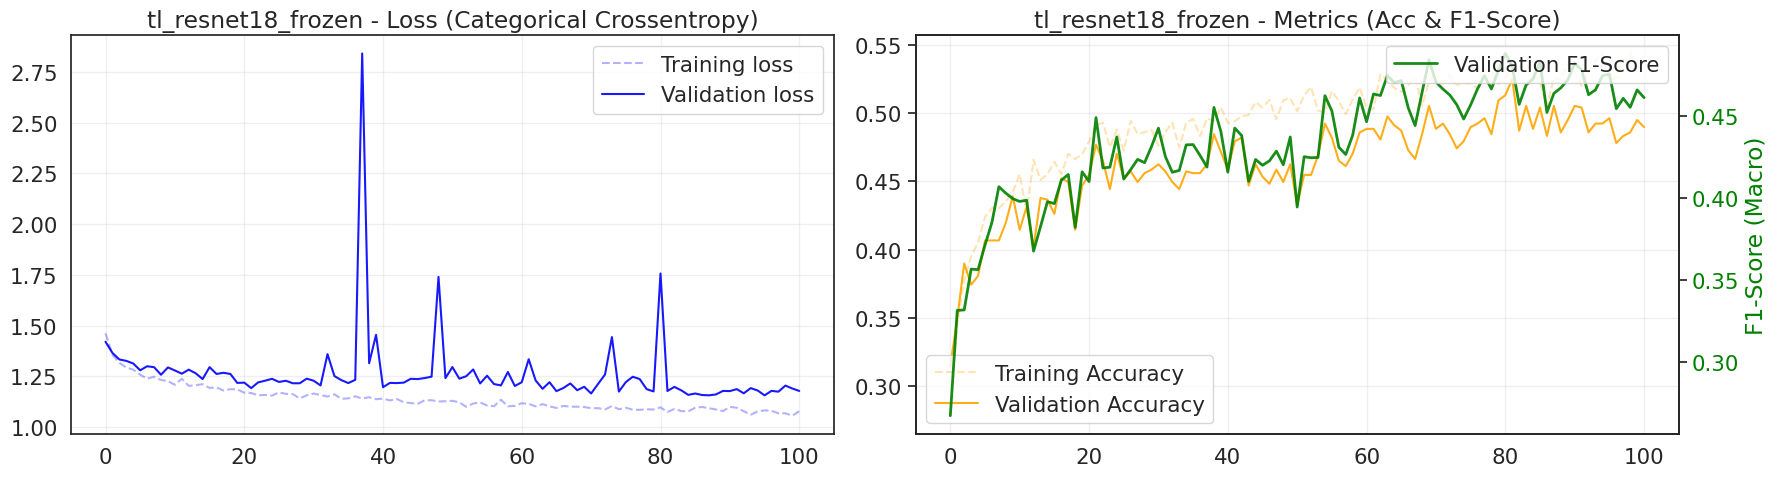

In [ ]:
# --- Evaluation and Plotting ---

final_val_f1 = round(max(tl_history['val_f1']) * 100, 2)
print(f'\nFinal best validation F1-Score: {final_val_f1}%')


# @title Plot History
# Create a figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(tl_history['train_loss'], label='Training loss', alpha=0.3, color='blue', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Validation loss', alpha=0.9, color='blue')
ax1.set_title(f'{experiment_name} - Loss (Categorical Crossentropy)')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of validation F1-Score (The COMPETITION METRIC) and Accuracy on the second axis
ax2.plot(tl_history['train_acc'], label='Training Accuracy', alpha=0.3, color='orange', linestyle='--')
ax2.plot(tl_history['val_acc'], label='Validation Accuracy', alpha=0.9, color='orange')
# F1-Score on a secondary axis (optional, but informative)
ax2_f1 = ax2.twinx()
ax2_f1.plot(tl_history['val_f1'], label='Validation F1-Score', alpha=0.9, color='green', linewidth=2)
ax2_f1.set_ylabel('F1-Score (Macro)', color='green')
ax2_f1.tick_params(axis='y', labelcolor='green')

ax2.set_title(f'{experiment_name} - Metrics (Acc & F1-Score)')
ax2.legend(loc='lower left')
ax2_f1.legend(loc='upper right')
ax2.grid(alpha=0.3)


# Adjust the layout and display the plot
plt.tight_layout()
plt.show()